In [45]:
import pandas as pd
import numpy as np
import json
import ast
from tqdm import tqdm
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from neo4j import GraphDatabase, basic_auth
import random
from scipy.stats import sem
import openai
import os
from dotenv import load_dotenv, find_dotenv

In [54]:
config_file = os.path.join(os.path.expanduser('~'), '.gpt_config.env')
load_dotenv(config_file)
api_key = os.environ.get('API_KEY')
api_version = os.environ.get('API_VERSION')
resource_endpoint = os.environ.get('RESOURCE_ENDPOINT')
openai.api_type = "azure"
openai.api_key = api_key
openai.api_base = resource_endpoint
openai.api_version = api_version


In [102]:
def jaccard_similarity(list1, list2):
    if list1 is not None and list2 is not None and len(list1) > 0 and len(list2) > 0:
        list1 = [item.lower() for item in list1]
        list2 = [item.lower() for item in list2]

        set1 = set(list1)
        set2 = set(list2)
        intersection = len(set1.intersection(set2))
        union = len(set1) + len(set2) - intersection
        if union == 0:
            return 0.0
        else:
            jaccard_similarity = intersection / union
            return jaccard_similarity
    else:
        return 0.0

    
def process_list(input_list):
    return remove_whitespace_and_newline(remove_empty_strings(input_list))

def remove_empty_strings(input_list):
    result_list = [item for item in input_list if item != '']
    return result_list

def remove_whitespace_and_newline(input_list):
    result_list = [item.strip() for item in input_list]
    return result_list
    
def extract_answer(text):
    pattern = r'{[^{}]*}'
    match = re.search(pattern, text)
    if match:
        return match.group()
    else:
        return None
    
def extract_by_splitting(text):
    compound_list = text.split(':')[1].split("Diseases")[0].split("], ")[0]+"]"
    disease_list = text.split(':')[-1].split("}")[0]
    resp = {}
    resp["Compounds"] = ast.literal_eval(compound_list)
    resp["Diseases"] = ast.literal_eval(disease_list)
    return resp

def get_gpt_performance(files):
    llm_performance_list = []
    llm_performance_list_metric = []
    for file_index, file in tqdm(enumerate(files)):
        df = pd.read_csv(os.path.join(PARENT_PATH, file))
        df.dropna(subset=["llm_answer"], inplace=True)
        llm_performance_list_across_questions = []
        for index, row in df.iterrows():
            cmp_gt = ast.literal_eval(row["compound_groundTruth"])
            disease_gt = ast.literal_eval(row["disease_groundTruth"])
            try:
                llm_answer = json.loads(extract_answer(row["llm_answer"]))
            except:
                try:
                    llm_answer = json.loads(row.llm_answer + '"]}')
                except:
                    try:
                        split_string = row.llm_answer.rsplit(',', 1)
                        join_string = split_string[0] + split_string[1]
                        llm_answer = json.loads(join_string + ']}')
                    except:
                        llm_answer = extract_by_splitting(row["llm_answer"])
            cmp_llm = llm_answer["Compounds"]
            disease_llm = llm_answer["Diseases"]
            cmp_similarity = jaccard_similarity(cmp_gt, cmp_llm)
            disease_similarity = jaccard_similarity(disease_gt, disease_llm)
            llm_performance = np.mean([cmp_similarity, disease_similarity])
            llm_performance_list_across_questions.append(llm_performance)
        llm_performance_list.append(llm_performance_list_across_questions)
        llm_performance_list_metric.append((np.mean(llm_performance_list_across_questions), np.std(llm_performance_list_across_questions), sem(llm_performance_list_across_questions), GPT_MODEL_LIST[file_index]))
    drug_repurpose_perf = pd.DataFrame(llm_performance_list_metric, columns=["performance_mean", "performance_std", "performance_sem", "model_name"])        
    return llm_performance_list, drug_repurpose_perf


def get_GPT_response(instruction, system_prompt, chat_model_id, chat_deployment_id, temperature=0):
    try:
        response = openai.ChatCompletion.create(
            temperature=temperature, 
            deployment_id=chat_deployment_id,
            model=chat_model_id,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": instruction}
            ]
        )
        if 'choices' in response \
        and isinstance(response['choices'], list) \
        and len(response) >= 0 \
        and 'message' in response['choices'][0] \
        and 'content' in response['choices'][0]['message']:
            return response['choices'][0]['message']['content']
        else:
            return 'Unexpected response'
    except:
        return None

def disease_entity_extractor(text):
    chat_deployment_id = 'gpt-35-turbo'
    chat_model_id = 'gpt-35-turbo'
    temperature = 0
    system_prompt = """
    You are an expert disease entity extractor from a sentence and report it as JSON in the following format:
    Diseases : <List of extracted entities>
    Note that, only report Diseases. Do not report any other entities like Genes, Proteins, Enzymes etc.
    """
    resp = get_GPT_response(text, system_prompt, chat_model_id, chat_deployment_id, temperature=0)
    try:
        entity_dict = json.loads(resp)
        return entity_dict["Diseases"]
    except:
        return None
    
        
def get_llama_performance(llama_df):
    llm_performance_list_across_questions = []
    for index, row in llama_df.iterrows():
        cmp_gt = ast.literal_eval(row["compound_groundTruth"])
        disease_gt = ast.literal_eval(row["disease_groundTruth"])
        text = row["llm_answer"]
        try:
            compounds_pattern = r'"Compounds": \[([^\]]*)\]'
            compounds_match = re.search(compounds_pattern, text)
            compounds_str = compounds_match.group(1) if compounds_match else ""
            compounds_list = [item.strip('"').strip() for item in compounds_str.split(",")]
            compounds_list = process_list(list(map(lambda x:x.split('"')[1], compounds_list)))

            diseases_pattern = r'"Diseases": \[([^\]]*)\]'
            diseases_match = re.search(diseases_pattern, text)
            diseases_str = diseases_match.group(1) if diseases_match else ""
            diseases_list = [item.strip('"').strip() for item in diseases_str.split(",")]
            diseases_list = process_list(list(map(lambda x:x.split('"')[1], diseases_list)))
            cmp_similarity = jaccard_similarity(cmp_gt, compounds_list)
            disease_similarity = jaccard_similarity(disease_gt, diseases_list)
            llm_performance = np.mean([cmp_similarity, disease_similarity])
            llm_performance_list_across_questions.append(llm_performance)
        except:
            compounds_pattern = r'Compounds:\s*\[([^\]]*)\]'
            diseases_pattern = r'Diseases:\s*\[([^\]]*)\]'
            compounds_match = re.search(compounds_pattern, text)
            diseases_match = re.search(diseases_pattern, text)
            compounds_str = compounds_match.group(1) if compounds_match else ""
            diseases_str = diseases_match.group(1) if diseases_match else ""
            compounds_list = [item.strip() for item in compounds_str.split(",")]
            diseases_list = [item.strip() for item in diseases_str.split(",")]        
            compounds_list = remove_whitespace_and_newline(compounds_list)
            diseases_list = remove_whitespace_and_newline(diseases_list)
            if '' in compounds_list or '' in diseases_list:
                try:
                    var1 = text.split("Compounds")[-1].split(":")[1].strip().split("}")[0]
                    var2 = re.split(r'\d+\.', var1)
                    var3 = [item.strip() for item in var2 if item.strip()]
                    if len(var3) == 1:
                        var4 = list(map(lambda x:x.split(", "), var3))[0]
                        if len(var4) == 1:
                            if "*" in var4[0]:
                                var4 = remove_whitespace_and_newline(remove_empty_strings(var4[0].split("*")))
                    else:
                        var4 = var3
                    var5 = []
                    for item in var4:
                        if "\n\n" in item:
                            var5.append(item.split("\n\n")[0])
                        else:
                            var5.append(item)
                    if len(var5) == 1:
                        if "\n" in var5[0]:
                            var6 = var5[0].split("\n")
                            var7 = []
                            for item in var6:
                                if '[' in item or ']' in item:
                                    continue
                                else:
                                    var7_ = item.split('"')[1]                                
                                    if var7_ != "Diseases":
                                        var7.append(var7_)
                    else:
                        var7 = var5
                    compounds_list = list(set(var7))
                    diseases_list = disease_entity_extractor(text)  
                    cmp_similarity = jaccard_similarity(cmp_gt, compounds_list)
                    disease_similarity = jaccard_similarity(disease_gt, diseases_list)
                    llm_performance = np.mean([cmp_similarity, disease_similarity])
                    llm_performance_list_across_questions.append(llm_performance)
                except:
                    llm_performance_list_across_questions.append(0)
            else:
                cmp_similarity = jaccard_similarity(cmp_gt, compounds_list)
                disease_similarity = jaccard_similarity(disease_gt, diseases_list)
                llm_performance = np.mean([cmp_similarity, disease_similarity])
                llm_performance_list_across_questions.append(llm_performance)
    return llm_performance_list_across_questions


    

In [173]:
PARENT_PATH = "../../../data/analysis_results/"

GPT_FILES = [
    "gpt_35_turbo_entity_recognition_based_node_retrieval_rag_based_drug_repurposing_questions_response.csv",
    "gpt_4_entity_recognition_based_node_retrieval_rag_based_drug_repurposing_questions_response.csv"
]
LLAMA_FILES = [
    "Llama_2_13b_chat_hf_entity_recognition_based_node_retrieval_rag_based_drug_repurposing_questions_response.csv"
]

GPT_MODEL_LIST = ["GPT-3.5-Turbo", "GPT-4"]
LLAMA_MODEL_LIST = ["Llama-2-13b"]


MODEL_LIST = ["Llama-2-13b", "GPT-3.5-Turbo", "GPT-4"]


In [153]:
%%time

gpt_llm_performance_list, gpt_drug_repurpose_perf = get_gpt_performance(GPT_FILES)

llama_df = pd.read_csv(os.path.join(PARENT_PATH, LLAMA_FILES[0]))
llama_llm_performance_list = get_llama_performance(llama_df)

llama_drug_repurpose_perf = pd.DataFrame({
    'performance_mean': [np.mean(llama_llm_performance_list)],
    'performance_std': [np.std(llama_llm_performance_list)],
    'performance_sem': [sem(llama_llm_performance_list)],
    'model_name': LLAMA_MODEL_LIST
})


llm_drug_repurpose_perf = pd.concat([llama_drug_repurpose_perf, gpt_drug_repurpose_perf], ignore_index=True)


2it [00:00, 40.98it/s]


CPU times: user 202 ms, sys: 14.2 ms, total: 216 ms
Wall time: 9.88 s


In [154]:
llm_drug_repurpose_perf


,performance_mean,performance_std,performance_sem,model_name
0,0.415263,0.220673,0.026960,Llama-2-13b
1,0.555489,0.176103,0.021514,GPT-3.5-Turbo
2,0.621062,0.200532,0.024499,GPT-4


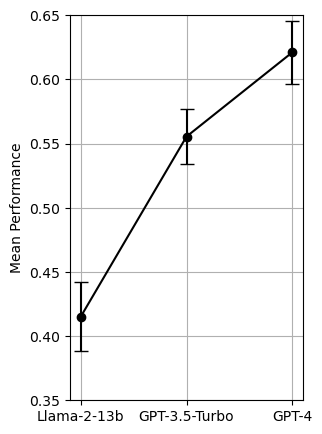

In [201]:


params = MODEL_LIST
mean_performance = llm_drug_repurpose_perf.performance_mean.values
std_deviation = llm_drug_repurpose_perf.performance_std.values
sem_value = llm_drug_repurpose_perf.performance_sem.values

fig = plt.figure(figsize=(3, 5))
plt.errorbar(params, mean_performance, yerr=sem_value, fmt='o-', capsize=5, label='Performance', color="black")
plt.ylabel('Mean Performance')
plt.grid(True)
plt.ylim(0.35,0.65)
plt.show()

figure_folder_name = "drug_repurposing"
fig_filename = "../../../data/analysis_results/figures/{}/performance_comparison_line_plot.svg".format(figure_folder_name)
fig.savefig(fig_filename, format='svg', bbox_inches='tight')



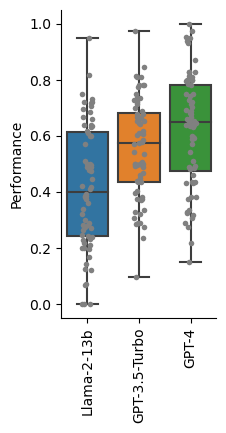

In [196]:
list1 = llama_llm_performance_list
list2 = gpt_llm_performance_list[0]
list3 = gpt_llm_performance_list[1]
data_to_plot = pd.DataFrame({
    'Group': [MODEL_LIST[0]] * len(list1) + [MODEL_LIST[1]] * len(list2) + [MODEL_LIST[2]] * len(list3),
    'Performance': list1 + list2 + list3
})

fig = plt.figure(figsize=(2, 4))
box_plot = sns.boxplot(x='Group', y='Performance', data=data_to_plot)
sns.despine(top=True, right=True)
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=90)
plt.xlabel('')
plt.ylabel('Performance')
stripplot = sns.stripplot(x='Group', y='Performance', data=data_to_plot, jitter=True, color='gray', size=4)
stripplot.set(xlabel="")
plt.show()

figure_folder_name = "drug_repurposing"
fig_filename = "../../../data/analysis_results/figures/{}/performance_comparison_box_plot.svg".format(figure_folder_name)
fig.savefig(fig_filename, format='svg', bbox_inches='tight')

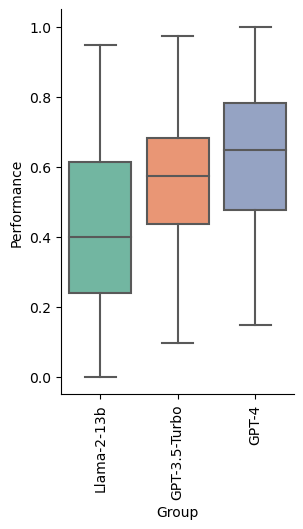

In [183]:
# Sample data for list1, list2, and list3
list1 = llama_llm_performance_list
list2 = gpt_llm_performance_list[0]
list3 = gpt_llm_performance_list[1]


data_to_plot = pd.DataFrame({
    'Group': [MODEL_LIST[0]] * len(list1) + [MODEL_LIST[1]] * len(list2) + [MODEL_LIST[2]] * len(list3),
    'Performance': list1 + list2 + list3
})

# Create the box plot
plt.figure(figsize=(3, 5))
box_plot = sns.boxplot(x='Group', y='Performance', data=data_to_plot, palette='Set2')
sns.despine(top=True, right=True)
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=90)
plt.ylabel('Performance')
# plt.grid(True)

sns.stripplot(x='Group', y='Performance', data=data_to_plot, jitter=True, color='black', size=4)

plt.show()
